## SGDでのパラメタの更新

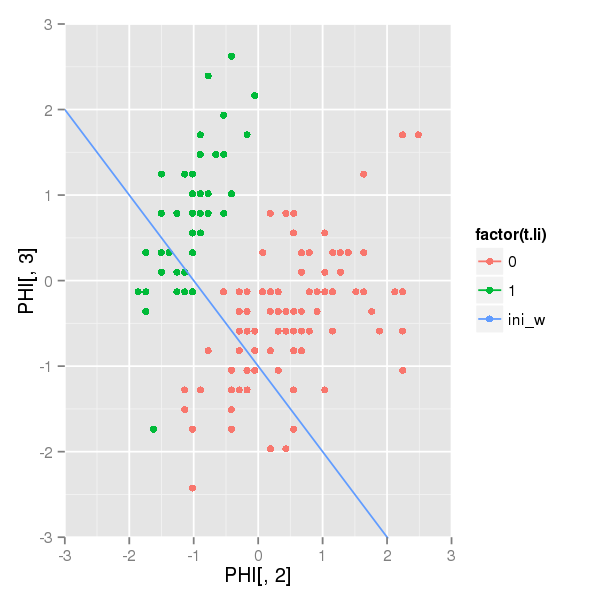

In [10]:
library("dplyr")
library("ggplot2")

x.df <- iris[,1:4] %>% scale
t.li <- iris$Species %>% as.integer %>% ifelse(.>=2,0,.) %>% as.matrix # 2値にしておく

phi <- function(x) c(1, x[1], x[2])
PHI <- t(apply(x.df, 1, phi))  # NxM
M   <- ncol(PHI)  # 特徴数(特徴空間の次元)
K   <- 1 # クラス数
# w   <- matrix(rnorm(M * K), M) # 初期化
w   <- matrix(c(1, 1, 1), M) # 初期化
y <- function(phi, w) {
  ## ロジスティック関数
    a <- phi %*% w
    1 /(1+exp(-a))
}
# y(PHI[c(1,2),],w)

dEw <- function(phi, t.li, w){
  # 誤算関数の勾配
  (y(phi,w)-t.li) * phi
}

x_line<-seq(-3,3,by=.1)
y_line<-function(x_line,w){
  a<- -(w[1,]/w[3,])
  b<- -(w[2,]/w[3,])
  return(a*x_line+b) # 0 = w0 + w1x1 + w2x2 --> x2 = ax + b
}
qplot(x=PHI[,2],y=PHI[,3],size=I(2),geom="point",col=factor(t.li))+
  geom_line(aes(x=x_line,y=y_line(x_line,w),col="ini_w"))+
  coord_cartesian(xlim=c(-3,3),y=c(-3,3))

In [106]:
mydraw<-function(n){
  plot.df <- data.frame(
             x=PHI[,2],
             y=PHI[,3],
    y_line_dat=y_line(PHI[,2],w),
    cols=factor(ifelse(y(PHI,w)<=.5,0,1))
  )
  p <- qplot(data=plot.df, x,y,col=cols,geom="point")+
    coord_cartesian(xlim=c(-3,3),ylim=c(-3,3))+
    ggtitle(paste("n:",n))
  print(p)
}
w_init <- w
update_w<-function(){
  eta <- 0.1  # 学習率
  for(n in 1:nrow(PHI)) {
    w <<- w -eta * dEw(PHI[n,], t.li[n], w)  # SGD
    if(n%%10==0){
        mydraw(n)
    }
  }
}
library("animation")
w   <- matrix(c(1, 1, 1), M) # 初期化
saveGIF(update_w(),interval = .5,img.name="s",movie.name = "logistic_sgd.gif")
w

Executing: 
'convert' -loop 0 -delay 50 s1.png s2.png s3.png s4.png s5.png s6.png
    s7.png s8.png s9.png s10.png s11.png s12.png s13.png s14.png
    s15.png 'logistic_sgd.gif'
Output at: logistic_sgd.gif


[1] TRUE

-1.107548
-1.354452
1.571635


* wの更新イメージ。本当は境界面も動いて欲しいのだが動かない。
![](logistic_sgd.gif)

## IRLS

In [104]:
w   <- matrix(c(1, 1, 1), M) # 初期化
N <- dim(y_n)[1]
error_rate<-function(w_new,w){
    sum((w_new - w)*(w_new - w)) / sum(w*w)
}
i<-1
while(T){
    y_n <- y(PHI,w)
    r_n <- y_n*(1-y_n)
    R_m <- diag(as.numeric(r_n), N, N )
    H <- t(PHI) %*% R_m %*% PHI
    w_new <- w - solve(H) %*% t(PHI) %*% (y_n-t.li)
    if(error_rate(w_new,w) < 0.001){
        paste("loop-end:",i) %>% print
        break
    }else{
        w <<- w_new
        i <<- i+1
    }
}
w

[1] "loop-end: 39"


,-165.5814
Sepal.Length,-231.4416
Sepal.Width,101.9604


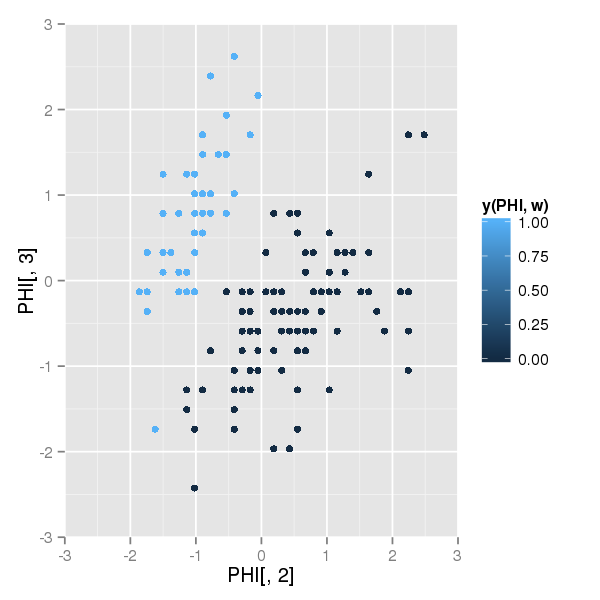

In [101]:
qplot(x=PHI[,2],y=PHI[,3],size=I(2),geom="point",col=y(PHI,w))+
  coord_cartesian(xlim=c(-3,3),y=c(-3,3))